# Exercise 1: Bayesian multiple shooting for latent ODEs (9 points)

The goal of this exercise is to observe firsthand the training instability for long trajectories that was discussed in the lecture. Specifically, we will replicate the experiment shown in Figure 1 and Appendix A of [Iakovlev et al. (2023)](https://arxiv.org/abs/2210.03466). We start by training a regular NODE with the structure given below

$
\begin{align}
x_i &\sim p(x_i) \\
θ_{dyn} &\sim p(\theta_{dyn}) \\
x_i &= ODEsolve(x_i, t_i, t_i, \theta_{dyn}), i > 1 \\
y_i \mid x_i &\sim p(y_i \mid g(x_i, \theta_{dec})) \\
\end{align}
$

where $y_i$ are observations, $x_i$ are latent representations of said observations, $\theta_{dyn}$ is the dynamics function, and $\theta_{dec}$ is the decoder function. In this exercise, we will be working with a 2 state data, which means we can work in the state space directly, no need for a latent space. In other words, our decoder $\theta_{dec}$ is the identity function.

In [4]:
# run this once
#pip install torchdiffeq

In [5]:
import torch.optim as optim

# Load the data
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from torchdiffeq import odeint

import matplotlib.pyplot as plt

from math import sqrt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Generation 

We will be working with simple sequence data representing the motion of a pendulum through its angle and angular velocity. Note that because our data is simple, we will not be using a **latent** ODE in this assignment; instead our model will be operating in the state space directly. In the more complex experiments presented in Iakovlev et al. (2023), an encoder/decoder structure is needed to reduce the dimensionality of the data before modelling the system's dynamics in the latent space.

Run the code in the cells below to generate a single sequence of pendulum motion (angle and angular velocity). Check that the plot looks like figure 14 in Iakovlev et al. (2023).

In [6]:
def generate_pendulum_data(t_max=3.0):
    """
    Generate a single 2D pendulum state trajectory [angle, velocity] using torchdiffeq solver,
    with data sampled every 0.1 seconds as specified in the paper.
    
    Args:
        t_max: End time (seconds)
        
    Returns:
        data: Tensor of shape [seq_length, 2]
        times: Tensor of shape [seq_length]
    """
    # Time points every 0.1 seconds, as specified in the paper
    t = torch.arange(0, t_max + 0.05, 0.1)  # Adding 0.05 for numerical stability
    
    # Initial conditions as per the paper (90 degrees position, 0 velocity)
    angle = torch.tensor(90.0 * np.pi/180.0, dtype=torch.float32)  # 90 degrees in radians
    velocity = torch.tensor(0.0, dtype=torch.float32)              # Initial velocity is zero
    initial_state = torch.stack([angle, velocity])
    
    # Pendulum ODE function: dy/dt = [velocity, -g*sin(angle)]
    def pendulum_dynamics(t, state):
        angle, velocity = state[0], state[1]
        dangle_dt = velocity
        dvelocity_dt = -9.81 * torch.sin(angle)
        return torch.stack([dangle_dt, dvelocity_dt])
    
    # Solve ODE using torchdiffeq with dopri5 solver (same as paper)
    trajectory = odeint(
        pendulum_dynamics, 
        initial_state, 
        t, 
        method='dopri5',  # Same solver used in the paper
        rtol=1e-5,
        atol=1e-5
    )
    
    # trajectory shape: [seq_length, 2]
    return trajectory, t

# Function to visualize a trajectory
def plot_pendulum_trajectory(trajectory, time):
    """
    Plot a pendulum trajectory in phase space and as time series.
    
    Args:
        trajectory: Shape [seq_length, 2] with angle and velocity
        time: Shape [seq_length] with time points
    """
    plt.figure(figsize=(12, 5))
    
    # Phase space plot
    plt.subplot(1, 2, 1)
    plt.plot(trajectory[:, 0], trajectory[:, 1])
    plt.xlabel('Angle (θ)')
    plt.ylabel('Angular Velocity (ω)')
    plt.title('Phase Space')
    plt.grid(True)
    
    # Time series plot
    plt.subplot(1, 2, 2)
    plt.plot(time, trajectory[:, 0], label='Angle (θ)')
    plt.plot(time, trajectory[:, 1], label='Angular Velocity (ω)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Time Series')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

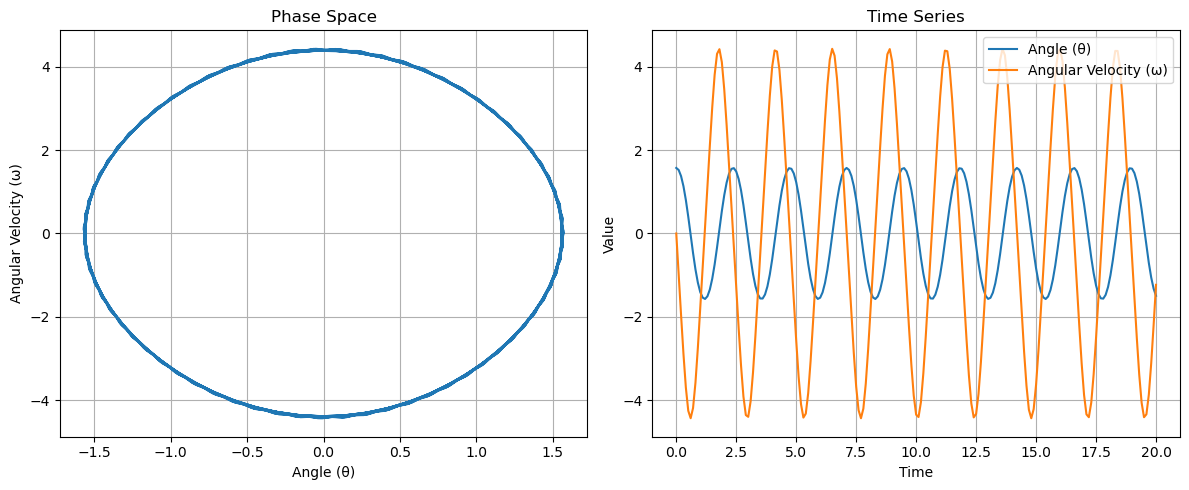

In [7]:
data, times = generate_pendulum_data(t_max=20.0)
plot_pendulum_trajectory(trajectory=data, time=times)

## Dynamics function (1 point)

We use a second-order dynamics function as explained in Appendix E.4.1 in Iakovlev et al. (2023). The function takes as input the position and the velocity of the pendulum and approximates their respective derivatives. The function itself is an MLP with 2 hidden layers, with hidden_dim=16 and Tanh non-linearity. 

Remember that latent dimension here is equal to 1, since we are working in the state space directly because our data is simple.

In [8]:
# Second-order dynamics model as described in Appendix A
class DynamicsFunction(nn.Module):
    def __init__(self, latent_dim, hidden_dim=16):
        super().__init__()
        # implement "an MLP with two hidden layers of size 16"
        # YOUR CODE HERE
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), 
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim), 
        )
        #raise NotImplementedError()
        
    def forward(self, x):
        # the function learns the derivative of the position and velocity
        # YOUR CODE HERE
        batch_size, latent_dim = x.shape
        out = self.net(x)
        idx = (int)(latent_dim/2)
        out[:, :idx] = x[:, idx:]
        return out
        #raise NotImplementedError()

In [9]:
def test_dynamics_function_visible():
    """Test the basic structure and functionality of DynamicsFunction."""
    import torch
    import torch.nn as nn
    
    # Test with small dimensions for simplicity
    latent_dim = 4
    model = DynamicsFunction(latent_dim)
    
    # Check basic structure
    assert isinstance(model, nn.Module), "DynamicsFunction should inherit from nn.Module"
    assert hasattr(model, 'net'), "DynamicsFunction should have a 'net' attribute"
    assert isinstance(model.net, nn.Sequential), "The network should be implemented as nn.Sequential"
    
    # Check that the model has the right number of layers
    layers = [module for module in model.net if isinstance(module, nn.Linear)]
    assert len(layers) == 3, "The network should have 3 linear layers (input->hidden, hidden->hidden, hidden->output)"
    
    # Test forward pass functionality
    batch_size = 2
    x = torch.randn(batch_size, latent_dim)
    output = model(x)
    
    # Check output shape
    assert output.shape == x.shape, f"Output shape {output.shape} should match input shape {x.shape}"
    
    # Check that the output contains the velocity unchanged in the first half
    velocity_input = x[:, latent_dim//2:]
    velocity_output = output[:, :latent_dim//2]
    assert torch.allclose(velocity_input, velocity_output), "The first half of the output should be the velocity from the input"
    
    print("All visible tests passed!")
test_dynamics_function_visible()

All visible tests passed!


## Regular Latent NODE (2 point)

Now we need to implement a regular latent ODE model, to show the behavior presented in Figure 1 in Iakovlev et al. (2023).

1. We want to learn both the parameters of the dynamics functio and the initial state of the sequence.
2. In the forward step, the model integrates the dynamics function (defined earlier) to predict both the angle and the angular velocity of the pendulum. You can use torchdiffeq's odeint() to perform the integration with the following parameters: dopri5 solver, and rtol=atol=1e-5. (1 point)
3. The model uses MSE loss to compare the predicted and true pendulum angles (note: angles alone, without velocity). (1 point)

Finish implementing the class functions accordingly.

In [10]:
# Neural ODE model (simplified for Figure 1 experiment)
class LatentNode(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim * 2  # x2 for position and velocity
        
        # Dynamics function
        # YOUR CODE HERE
        self.dynamics_func = DynamicsFunction(self.latent_dim)
        self.func_wrapper = nn.Module()
        self.func_wrapper.forward = lambda t,x : self.dynamics_func(x.unsqueeze(0)).squeeze(0)
        self.initial_state = nn.Parameter(torch.randn(self.latent_dim), requires_grad=True)
        
        #raise NotImplementedError()
        
    def forward(self, times):
        # Use initial state
        # YOUR CODE HERE
        y_pred = odeint(func=self.func_wrapper, y0 = self.initial_state, t = times, method='dopri5', rtol=1e-5, atol=1e-5)
        y_pred = y_pred.reshape(times.shape[0], -1, self.latent_dim)
        
        return y_pred
        #raise NotImplementedError()
    
    def compute_loss(self, y_true, times):
        """Compute MSE loss as used in Figure 1 experiment"""
        # YOUR CODE HERE
        y_pred = self.forward(times)
        print(y_pred.shape)
        y_pred = y_pred[:, :, :self.latent_dim//2]
        loss = torch.nn.functional.mse_loss(y_true, y_pred)
        return loss
        #raise NotImplementedError()

In [11]:
def test_latent_node_visible():
    """Test the basic structure and functionality of LatentNode."""
    import torch
    import torch.nn as nn
    from torchdiffeq import odeint
    
    # Initialize model with small latent dimension
    latent_dim = 1  # This means actual dim will be 2 (position + velocity)
    model = LatentNode(latent_dim)
    
    # Check basic structure
    assert isinstance(model, nn.Module), "LatentNode should inherit from nn.Module"
    assert hasattr(model, 'dynamics_func'), "LatentNode should have a 'dynamics_func' attribute"
    assert isinstance(model.dynamics_func, DynamicsFunction), "dynamics_func should be an instance of DynamicsFunction"
    assert hasattr(model, 'initial_state'), "LatentNode should have an 'initial_state' attribute"
    assert isinstance(model.initial_state, nn.Parameter), "initial_state should be a torch Parameter"
    assert model.initial_state.shape == (latent_dim * 2,), f"initial_state should have shape ({latent_dim * 2},)"
    
    # Test forward pass
    times = torch.linspace(0, 1, 10)
    trajectory = model(times)
    
    # Check output shape [time_steps, batch_size, latent_dim*2]
    expected_shape = (len(times), 1, latent_dim * 2)
    assert trajectory.shape == expected_shape, f"Output shape {trajectory.shape} should match {expected_shape}"
    
    # Test compute_loss method
    y_true = torch.sin(times.unsqueeze(1))  # Simple sine wave as ground truth
    loss = model.compute_loss(y_true, times)
    
    # Check that loss is a scalar
    assert loss.ndim == 0, "Loss should be a scalar"
    assert not torch.isnan(loss), "Loss should not be NaN"
    assert not torch.isinf(loss), "Loss should not be infinite"
    
    print("All visible tests passed!")
    
test_latent_node_visible()


torch.Size([10, 1, 2])
All visible tests passed!


/tmp/ipykernel_285/1979715874.py:31: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(y_true, y_pred)


## Training and visualizing the loss (1 point) 

Complete the code below to train the Neural ODE model defined above.

1. Implement the Adam optimizer with an ExponentialLR scheduler that decreases the learning rate from 3e-4 to 1e-5.
2. Following the paper's methodology, begin training with only the first 10 points of the sequence, then double the 3. sequence length every iterations_per_length iterations.
4. Track and store appropriate metrics during training to reproduce the visualization at the end.

Your implementation should generate a loss curve similar to Figure 1 in the paper, demonstrating:

1. Convergence for short sequences (length < 10)
2. Characteristic peaks after each sequence length increase
3. Failure to converge for sufficiently long sequences

Note: The provided code is configured to train for 100 epochs, whereas the paper reports 3000 iterations per sequence length. Feel free to extend the training duration if needed, but be aware that longer training will significantly increase computation time, especially without GPU acceleration.

In [22]:
def train_and_visualize_model_instability(
    model, 
    data,
    times,
    iterations_per_length=3000,
    initial_length=10,
    print_every=100,
    visualize=False
):
    """
    Train the model on sequences of increasing length to demonstrate instability
    as shown in Figure 1 of the paper.
    """
    # Initialize storage for losses and converged parameters
    all_losses = []
    
    # Start with short sequence and double length until we reach full trajectory
    seq_len = initial_length
    seq_lengths = []
    
    # Calculate maximum length
    max_length = len(times)
    
    # For plotting - create continuous x-axis for iterations
    cumulative_iterations = []
    current_iteration = 0
    
    # YOUR CODE HERE
    initial_lr = 3e-4
    final_lr = 1e-5
    num_epochs = 100
    gamma = (final_lr/initial_lr)**(1/num_epochs)
    optimizer = torch.optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    
    for epoch in range(num_epochs):
        for it in range(iterations_per_length):
            optimizer.zero_grad()
            
            loss = model.compute_loss(data[:, :initial_length], times[:initial_length])
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            all_losses.append(loss.item())
            seq_lengths.append(seq_len)
            
            seq_len *= 2
    
    #raise NotImplementedError()
    
    # Plot training loss curve as in the paper (continuous line)
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_iterations, all_losses)
    
    # Add vertical lines and labels to mark where sequence length changes
    prev_iteration = 0
    for i, seq_len in enumerate(seq_lengths):
        if i > 0:  # Skip the first one since it starts at 0
            iteration_mark = i * iterations_per_length
            plt.axvline(x=iteration_mark, color='gray', linestyle='--', alpha=0.7)
            plt.text(iteration_mark, 1, f'N={seq_len}', 
                rotation=0, 
                verticalalignment='bottom',
                horizontalalignment='left',
                transform=plt.gca().get_xaxis_transform())
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss')
    #plt.title('Training Loss for Different Sequence Lengths')
    plt.grid(True)
    plt.yscale('log')  # Log scale as in the paper
    plt.savefig('training_loss.png')
    plt.show()
    
    return all_losses, seq_lengths, cumulative_iterations


ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

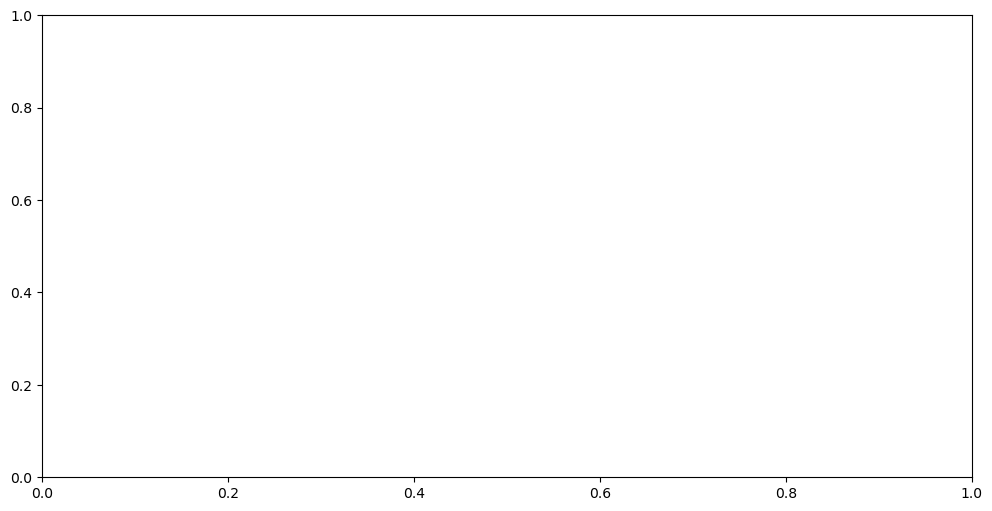

In [23]:
def test_train_and_visualize_model_instability_return_values():
    """Test that the function returns the expected types and structure."""
    # Setup a simple mock model
    class MockModel:
        def __init__(self):
            self.params = [torch.nn.Parameter(torch.randn(2, 2))]
            
        def parameters(self):
            return self.params
            
        def compute_loss(self, data, times):
            # Mock loss that depends on sequence length to simulate NODE instability
            # Longer sequences produce higher loss values
            return torch.tensor(0.1 * len(data), requires_grad=True)
    
    model = MockModel()
    data = torch.randn(20, 3)  # 20 time steps, 3 dimensions
    times = torch.linspace(0, 1, 20)
    
    # Call function with small number of iterations for testing
    all_losses, seq_lengths, cumulative_iterations = train_and_visualize_model_instability(
        model, data, times, iterations_per_length=10, initial_length=5, print_every=5, visualize=False
    )
    
    # Check return types
    assert isinstance(all_losses, list), "all_losses should be a list"
    assert isinstance(seq_lengths, list), "seq_lengths should be a list"
    assert isinstance(cumulative_iterations, list), "cumulative_iterations should be a list"
    
    # Check that lengths match expectations
    assert len(seq_lengths) > 0, "seq_lengths should not be empty"
    assert len(all_losses) == len(cumulative_iterations), "all_losses and cumulative_iterations should have the same length"
    
    # Check sequence length progression (doubles each time)
    for i in range(1, len(seq_lengths)):
        assert seq_lengths[i] == seq_lengths[i-1] * 2, "Sequence length should double each time"
    
    # Check that we have the correct number of losses for each sequence length
    iterations_per_length = 10
    assert len(all_losses) == iterations_per_length * len(seq_lengths), "Should have iterations_per_length losses for each sequence length"
    
    print("All visible tests passed!")

test_train_and_visualize_model_instability_return_values()


In [ ]:
model = LatentNode(latent_dim=1)
_ = train_and_visualize_model_instability(model, 
                                          data, 
                                          times,
                                          iterations_per_length=100,
                                          initial_length=10,
                                          print_every=10,
                                          visualize=False)

## Deriving Bayesian multiple shooting (2 points)

1. Write the posterior distribution $p(\theta_{dyn}, \theta_{dec}, s_{1:B} \mid y_{1:N})$ of the model using Bayesian multiple shooting as presented in the paper. Then explain how amortized inference is implemented to approximate this posterior, including:

- The structure of the variational distribution $q(\theta_{dyn}, \theta_{dec}, s_{1:B})$
- The role of the encoder hθenc in amortization
- How this enables efficient parallel computation across shooting blocks

2. Derive the ELBO loss used to train the multiple shooting model by:

- Starting with the general variational objective
- Expanding it to show all components (data likelihood, continuity prior, parameter priors)
- Explaining how each term in the ELBO contributes to the model (especially highlighting how the continuity prior terms enforce trajectory smoothness)

YOUR ANSWER HERE

## Latent Node with Multiple Shooting (3 points)

Implement the Neural ODE class with Bayesian sparse multiple shooting as described in the paper. Focus on these key components:

1. Define shooting variables as stochastic latent variables with appropriate distributions.
2. Partition the trajectory into a configurable number of blocks (num_blocks), creating efficient sub-trajectories.
3. For each block, compute the trajectory segment by integrating the dynamics function from the corresponding shooting variable.
4. Construct the ELBO loss with three essential terms: Reconstruction loss (data likelihood), KL divergence for the first shooting variable (initial state prior), Continuity KL divergence (enforcing smoothness between blocks)

When trained properly, this model should demonstrate stable convergence across increasing sequence lengths, unlike the standard Neural ODE implementation. Note that the loss scale is much larger here than the MSE loss, as long as the pattern shows clear decrease your implementation should be correct.

In [ ]:
# Multiple shooting version of the LatentNODE model with Sparse Bayesian approach
class MSLatentNODE(nn.Module):
    def __init__(self, latent_dim=2, num_blocks=5):
        """
        Multiple shooting version of the LatentNODE model with Sparse Bayesian approach.
        
        Args:
            latent_dim: Dimension of the latent space (per coordinate)
            num_blocks: Number of shooting blocks to use
        """
        super().__init__()
        self.latent_dim = latent_dim * 2  # x2 for position and velocity
        self.num_blocks = num_blocks
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def sample_shooting_vars(self):
        """
        Sample shooting variables from their variational distributions.
        This implements the reparameterization trick for backpropagation.
        """
        shooting_vars = []
        # YOUR CODE HERE
        raise NotImplementedError()
        return shooting_vars
    
    def forward(self, times):
        """
        Forward pass using multiple shooting with sampled shooting variables.
        
        Args:
            times: Time points for evaluation
            
        Returns:
            Complete trajectory by stitching together sub-trajectories
        """
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def _get_block_boundaries(self, times):
        """
        Determine the start and end indices for each block.
        Creates blocks with approximately equal size by default.
        """
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def compute_continuity_kl_divergence(self, times):
        """
        Compute KL divergence for the continuity prior as in the paper.
        This is one of the key innovations in the paper's approach.
        """
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def compute_loss(self, y_true, times):
        """
        Compute total loss following the paper's ELBO formulation:
        ELBO = reconstruction term - KL divergence terms
        
        Args:
            y_true: Ground truth trajectory
            times: Time points
            
        Returns:
            Negative ELBO (loss to minimize)
        """
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
def test_mslatentnode_initialization():
    """Test that the MSLatentNODE model initializes correctly."""
    # Create model with default parameters
    latent_dim = 2
    num_blocks = 5
    model = MSLatentNODE(latent_dim=latent_dim, num_blocks=num_blocks)
    
    # Check model attributes
    assert model.latent_dim == latent_dim * 2, "Latent dimension should be doubled for position and velocity"
    assert model.num_blocks == num_blocks, "Number of blocks should match input"
    
    # Check that shooting variables are initialized
    assert len(model.shooting_means) == num_blocks, "There should be one mean parameter per block"
    assert len(model.shooting_log_stds) == num_blocks, "There should be one log_std parameter per block"
    
    # Check that first shooting variable is initialized to pendulum initial conditions
    assert abs(model.shooting_means[0][0].item() - (np.pi/2.0)) < 1e-5, "First shooting mean should be initialized to π/2 (90 degrees)"
    assert abs(model.shooting_means[0][latent_dim].item()) < 1e-5, "First shooting velocity should be initialized to 0"
    
    print("Initialization test passed!")

test_mslatentnode_initialization()

def test_mslatentnode_block_boundaries():
    """Test that block boundaries are correctly calculated."""
    model = MSLatentNODE(latent_dim=2, num_blocks=3)
    times = torch.linspace(0, 1, 10)
    
    # Get block boundaries
    boundaries = model._get_block_boundaries(times)
    
    # Check that we have the correct number of boundaries
    assert len(boundaries) == 3, "Should have 3 boundary pairs for 3 blocks"
    
    # Check that the boundaries cover the entire range
    assert boundaries[0][0] == 0, "First block should start at index 0"
    assert boundaries[-1][1] == len(times), "Last block should end at the last time point"
    
    # Check that blocks are contiguous
    for i in range(len(boundaries)-1):
        assert boundaries[i][1] == boundaries[i+1][0], "Blocks should be contiguous"
    
    print("Block boundaries test passed!")
    
test_mslatentnode_block_boundaries()

def test_mslatentnode_forward():
    """Test that the forward pass produces output of the correct shape."""
    latent_dim = 2
    num_blocks = 3
    model = MSLatentNODE(latent_dim=latent_dim, num_blocks=num_blocks)
    
    # Create some time points
    times = torch.linspace(0, 1, 20)
    
    # Run forward pass
    trajectory = model(times)
    
    # Check output shape
    expected_shape = (len(times), 1, latent_dim * 2)  # (time, batch, features)
    assert trajectory.shape == expected_shape, f"Expected shape {expected_shape}, got {trajectory.shape}"
    
    print("Forward pass test passed!")

test_mslatentnode_forward()



In [ ]:
model = MSLatentNODE(latent_dim=1)
_ = train_and_visualize_model_instability(model, 
                                          data, 
                                          times,
                                          iterations_per_length=100,
                                          initial_length=10,
                                          print_every=10,
                                          visualize=False)